In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [3]:
# Code -- https://github.com/alexandru-dinu/cae
# DataBase -- https://www.kaggle.com/hsankesara/flickr-image-dataset




img_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

31783


In [4]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((218,178))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
#         print("hey  "*4 + str(index))
        img = mpimg.imread(img_dir+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
#         img = (img - 255.0) / 255.0
        return img

In [5]:
batch_size=20
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


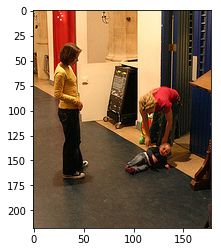

In [6]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[15]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

In [9]:
num_images_to_show = 5


valid_dataset = ImageData(is_train=False)
batch_size = num_images_to_show
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)


In [10]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self,num_channels_in_encoder):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [11]:
device

'cuda'

In [12]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self,num_channels_in_encoder):
        super(Generator, self).__init__()
        
        # DECODER
#         self.latent_fc1 = nn.Sequential(
#             nn.Linear(latent_size,1000),
#             nn.Sigmoid(),
#         )
#         self.latent_fc2 = nn.Sequential(
#             nn.Linear(1000,54*44),
#             nn.Sigmoid(),
#         )
        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [13]:
num_channels_in_encoder = 28
netE28 = Encoder(num_channels_in_encoder).to(device)
netE28.apply(weights_init)

num_channels_in_encoder = 28
netG28 = Generator(num_channels_in_encoder).to(device)
netG28.apply(weights_init)

netG28.load_state_dict(torch.load("/kaggle/input/trained-image-compressionmodels/netG28.model"))
netE28.load_state_dict(torch.load("/kaggle/input/trained-image-compressionmodels/netE28.model"))


netE28.eval()
netG28.eval()


reconstructed_img_28 = netG28(netE28(valid_batch))





del netE28
del netG28
torch.cuda.empty_cache()

In [14]:
num_channels_in_encoder = 16
netG16 = Generator(num_channels_in_encoder).to(device)
netG16.apply(weights_init)

num_channels_in_encoder = 16
netE16 = Encoder(num_channels_in_encoder).to(device)
netE16.apply(weights_init)

netG16.load_state_dict(torch.load("/kaggle/input/trained-image-compressionmodels/32_netG.model"))
netE16.load_state_dict(torch.load("/kaggle/input/trained-image-compressionmodels/32_netE.model"))


netE16.eval()
netG16.eval()
reconstructed_img_16 = netG16(netE16(valid_batch))

del netE16
del netG16
torch.cuda.empty_cache()

In [15]:
num_channels_in_encoder = 8
netE8 = Encoder(num_channels_in_encoder).to(device)
netE8.apply(weights_init)


netG8 = Generator(num_channels_in_encoder).to(device)
netG8.apply(weights_init)


netG8.load_state_dict(torch.load("/kaggle/input/trained-image-compressionmodels/16_netG.model"))
netE8.load_state_dict(torch.load("/kaggle/input/trained-image-compressionmodels/16_netE.model"))


netG8.eval()
netE8.eval()

reconstructed_img_8 = netG8(netE8(valid_batch))

del netE8
del netG8
torch.cuda.empty_cache()

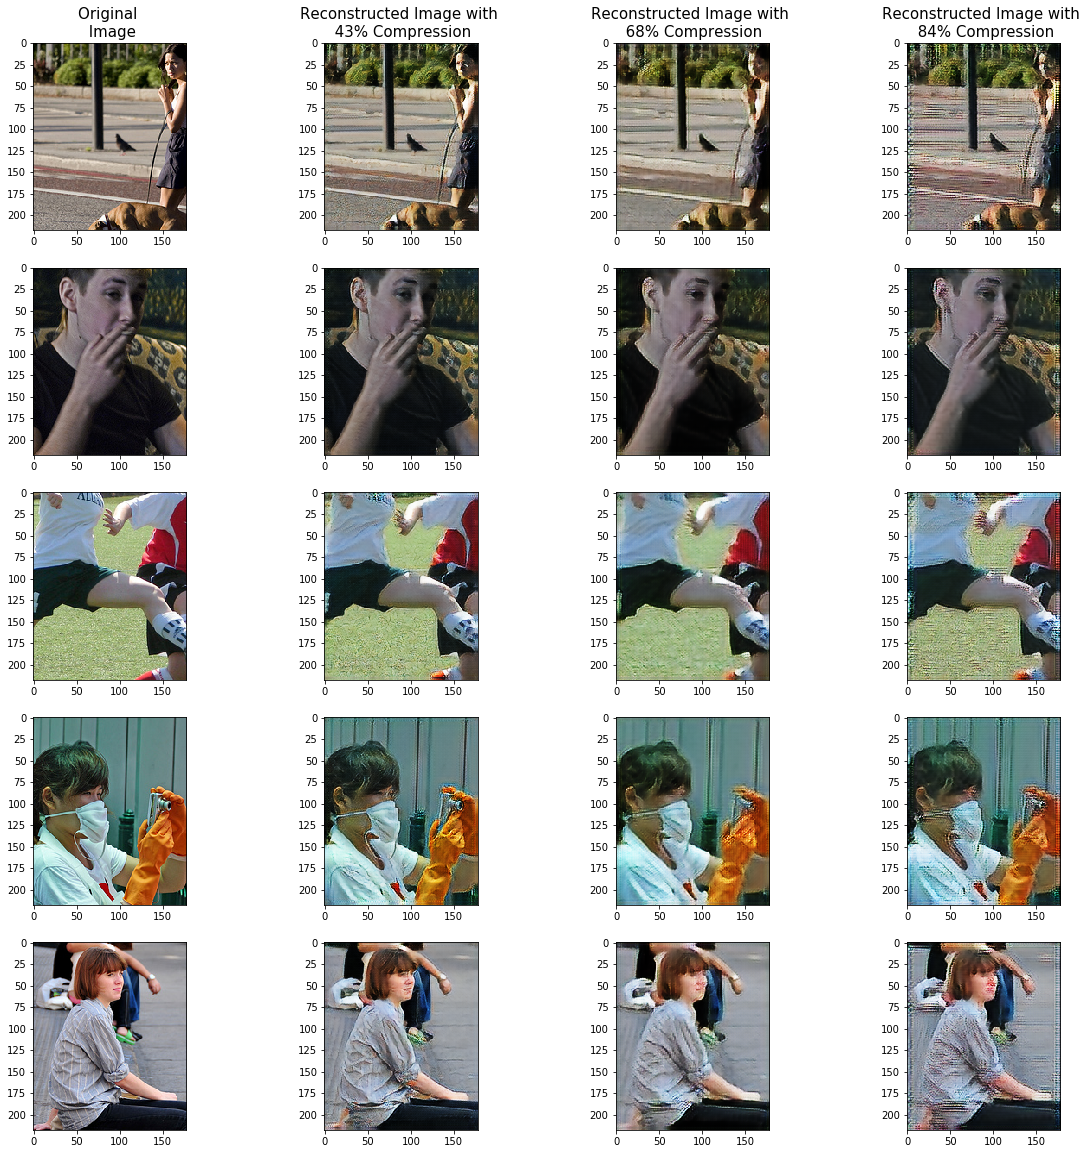

In [16]:

f, axarr = plt.subplots(num_images_to_show,4)

axarr[0,0].title.set_text('Original \n Image')
axarr[0,1].title.set_text('Reconstructed Image with \n 43% Compression')
axarr[0,2].title.set_text('Reconstructed Image with \n 68% Compression')
axarr[0,3].title.set_text('Reconstructed Image with \n 84% Compression')

for i in range(4):
    axarr[0,i].title.set_fontsize(15)

for i in range(num_images_to_show):
    axarr[i,0].imshow((valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5)
    axarr[i,1].imshow((reconstructed_img_28[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5)
    axarr[i,2].imshow((reconstructed_img_16[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5)
    axarr[i,3].imshow((reconstructed_img_8[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

In [17]:
plt.savefig('results.png')
f.savefig('results.png')

<Figure size 432x288 with 0 Axes>